In [18]:
import cv2
import numpy as np
import pandas as pd
from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential

IMAGE_SIZE = (64, 64, 3)

def extract_training_data(filename, csv_filename, image_size=(64, 64, 3)):
    cap = cv2.VideoCapture(filename)
    labels = pd.read_csv(csv_filename, sep="\t")

    frame_counter = 0
    processed_frames = []

    training_images = []
    training_label_ids = []
    while True:
        frame_counter += 1
        result, frame = cap.read()
        if result and frame_counter % 12 == 0:
            frame = frame / 255
            # cv2.imshow("img", frame)
            resized = cv2.resize(frame, image_size[:2])
            processed_frames.append(resized)
            if len(processed_frames) >= 4:
                # cv2.imshow('frame', resized)

                stacked_image = np.concatenate(processed_frames, axis=2)
                # training_labels.append(labels[frame_counter])
                training_images.append(stacked_image)
                # training_images.append(processed_frames.copy())
                training_label_ids.append(frame_counter)
                processed_frames.pop(0)

        if cv2.waitKey(1) & 0xFF == ord('q') or not result:
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

    training_images = np.array(training_images)
    training_labels = labels.loc[training_label_ids]

    assert training_images.shape[0] == training_labels.shape[0]
    return training_images, training_labels

In [19]:
images, labels = extract_training_data("Data/20171029-201949.h264.avi", "Data/20171029-201949.h264.csv", IMAGE_SIZE)

In [20]:
y_train = labels.as_matrix(columns=labels.columns[1: -1])
y_train.shape

(1741, 3)

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='linear'))

model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        3488      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 92259     
Total params: 95,747
Trainable params: 95,747
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1671 samples, validate on 70 samples
Epoch 1/10
1671/1671 [==============================] - 9s - loss: 4.8838 - val_loss: 0.3169
Epoch 2/10
1671/1671 [==============================] - 8s - loss: 0.1913 - val_loss: 0.1946
Epoch 3/10
1671/1671 [==============================] - 8s - loss: 0.1043 - val_loss: 0.1839
Epoch 4/10
1671/1671 [==============================] - 8s - loss: 0.0880 - val_loss: 0.2009
Epoch 5/10
1671/1671 [==============================] - 8s - loss: 0.0776 - val_loss: 0.2169
Epoch 6/10
1671/1671 [==============================] - 8s - loss: 0.0692 - val_loss: 0.2306
Epoch 7/10
1671/1671 [==============================] - 8s - loss: 0.0624 - val_loss: 0.2422
Epoch 8/10
1671/1671 [==============================] - 8s - loss: 0.0561 - val_loss: 0.2430
Epoch 9/10
1671/1671 [==============================] - 8s - loss: 0.0513 - val_loss: 0.2557
Epoch 10/10
1671/1671 [==============================] - 8s - loss: 0.0470 - val_loss: 0.2568


In [23]:
test_images, _ = extract_training_data("Data/20171029-201639.h264.avi", "Data/20171029-201639.h264.csv", IMAGE_SIZE)

prediction = model.predict(test_images)

In [24]:
prediction

array([[ 0.16954336, -0.12691733,  0.97084445],
       [ 0.14020011, -0.10938781,  0.94753146],
       [ 0.15274979, -0.10426682,  0.94020349],
       ..., 
       [ 0.21040317, -0.02484362,  1.13086426],
       [ 0.13561106,  0.17088383,  1.03399181],
       [-0.48272845,  0.1207922 ,  1.06013715]], dtype=float32)

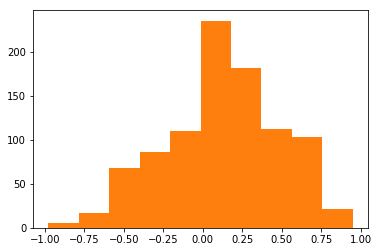

In [28]:
import matplotlib.pyplot as plt
plt.hist(prediction[:, 0])
plt.show()

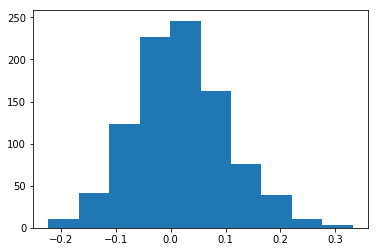

In [29]:
plt.hist(prediction[:, 1])
plt.show()

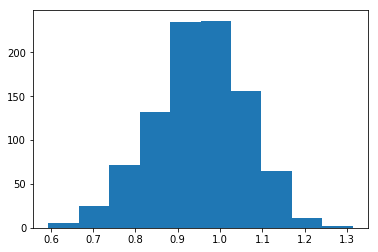

In [30]:
plt.hist(prediction[:, 2])
plt.show()

# LSTM

In [31]:
model = Sequential()
model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(LSTM(32, return_sequences=False))
model.add(Dense(3, activation='linear'))

model.compile(loss="mse", optimizer="adam")
model.summary()

ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2